In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from shapely.geometry import Point, Polygon, MultiPolygon,box
from scipy.spatial import cKDTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,ConstantKernel


# Etapa 1 : Obtener datos .kml de la ciudad de La Plata.

In [2]:
gdf = gpd.read_file("laplata_cascourbano.kml", driver="KML")
display(gdf)

/home/andy/.local/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'laplata_cascourbano.kml': 'La Plata' (default), 'La Plata (#2)', 'La Plata (#3)'. Specify layer parameter to avoid this warning.
  result = read_func(


,Name,Description,geometry
0,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.93986 -34.92733 0, -57.9..."
1,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.9475 -34.94511 0, -57.94..."
2,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.93726 -34.93996 0, -57.9..."
3,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.9535 -34.95246 0, -57.95..."
4,La Plata,descripción: <br>name: La Plata <br>descriptio...,"POLYGON Z ((-57.93649 -34.93926 0, -57.93649 -..."
5,La Plata,descripción: <br>name: La Plata <br>descriptio...,GEOMETRYCOLLECTION Z (LINESTRING Z (-57.94451 ...


In [3]:
# Chequear cuántas capas tiene el archivo kml
for layer in fiona.listlayers("laplata_cascourbano.kml"):
    print(layer)

La Plata
La Plata (#2)
La Plata (#3)


In [4]:
# Convertir el archivo kml a geojson
gdf.to_file("salida.geojson", driver='GeoJSON')

<AxesSubplot:>

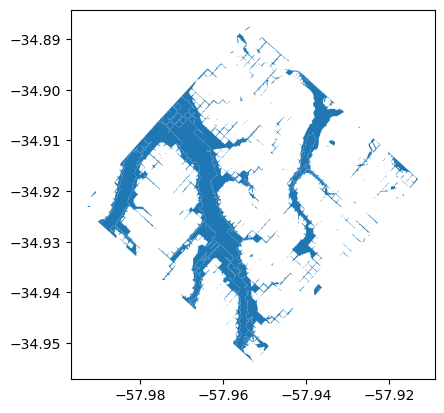

In [5]:
# Plotear el archivo geojson
gdf = gpd.read_file("salida.geojson")
gdf.plot()

# Etapa 2: Obtener las coordenadas de los puntos de la ciudad


In [6]:
# Extraer los límites  del área de La Plata

bounds = gdf.total_bounds  # Devuelve [minx, miny, maxx, maxy]

# Extraer las coordenadas de los puntos de la ciudad
west_longitude = bounds[0]   # Minimum X (westernmost)
south_latitude = bounds[1]   # Minimum Y (southernmost) 
east_longitude = bounds[2]   # Maximum X (easternmost)
north_latitude = bounds[3]   # Maximum Y (northernmost)


In [7]:
# Crear diccionario con las coordenadas de las esquinas de la ciudad
bounds = {
    'x_min': west_longitude,
   'x_max': east_longitude, 
    'y_min': south_latitude,
    'y_max': north_latitude
}


In [8]:
# Imprimir las coordenadas de las esquinas
for corner, coord in bounds.items():
    print(f"{corner}: {coord:.6f}")

x_min: -57.992667
x_max: -57.913120
y_min: -34.953843
y_max: -34.887489


# Etapa 3 : Obtener datos de densidad poblacional de la ciudad de La Plata.

In [9]:
# Dataset de densidad poblacional Argentina 2020 (1km resolución, ~4M puntos)
df_arg = pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv")

In [10]:
# Function to extract data from a specific city in the complete dataset
def extract_city_data(df: pd.DataFrame, city_name: str, bounds_dict: dict) -> pd.DataFrame:
    """
    Extract data for a specific city from the dataset.
    
    Args:
        city_name (str): Name of the city to extract data for
        bounds_dict (dict): Dictionary containing city boundaries with keys:
                           'x_min', 'x_max', 'y_min', 'y_max'
    
    Returns:
        pd.DataFrame: Filtered data for the specified city
    """
    
    # Filter data based on city boundaries
    city_data = df[
        (df['X'] >= bounds_dict['x_min']) & 
        (df['X'] <= bounds_dict['x_max']) & 
        (df['Y'] >= bounds_dict['y_min']) & 
        (df['Y'] <= bounds_dict['y_max'])
    ]
    
    # Save filtered data to CSV file
    output_file = f"{city_name.lower().replace(' ', '_')}_population_2020.csv"
    city_data.to_csv(output_file, index=False)
    
    print(f"Extracted data: {len(city_data)} rows for {city_name}")
    
    return city_data


In [11]:
# Extract data for La Plata
la_plata_data = extract_city_data(df_arg, 'La Plata', bounds)

Extracted data: 80 rows for La Plata


In [12]:
la_plata_data.head()


,X,Y,Z
2005769,-57.988750,-34.887916,4390.450195
2005770,-57.980416,-34.887916,4219.690918
2005771,-57.972083,-34.887916,3577.566895
2005772,-57.963750,-34.887916,4450.521973
2005773,-57.955416,-34.887916,3841.554199


In [13]:
bbox = box(
    bounds['x_min'], bounds['y_min'],
    bounds['x_max'], bounds['y_max']
)

In [14]:
# Create GeoDataFrame from the bounding box
gdf_la_plata = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# Display the result
gdf_la_plata.to_file("la_plata_bounds.geojson", driver='GeoJSON')

# Etapa 4 : Transformar datos de densidad poblacional de la ciudad de La Plata.

In [15]:
# Leer el archivo CSV de densidad de población de La Plata
df = pd.read_csv('la_plata_population_2020.csv')
    
# Crear geometría de puntos usando X,Y como longitud,latitud
geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
    

In [16]:
# Crear GeoDataFrame
CRS_4326 = 4326
gdf_densidad= gpd.GeoDataFrame(df, geometry=geometry, crs=CRS_4326)
    
# Agregar columna de densidad con nombre descriptivo
gdf_densidad['densidad_poblacional_lp'] = gdf_densidad['Z']
gdf_densidad


,X,Y,Z,geometry,densidad_poblacional_lp
0,-57.988750,-34.887916,4390.450195,POINT (-57.98875 -34.88792),4390.450195
1,-57.980416,-34.887916,4219.690918,POINT (-57.98042 -34.88792),4219.690918
2,-57.972083,-34.887916,3577.566895,POINT (-57.97208 -34.88792),3577.566895
3,-57.963750,-34.887916,4450.521973,POINT (-57.96375 -34.88792),4450.521973
4,-57.955416,-34.887916,3841.554199,POINT (-57.95542 -34.88792),3841.554199
...,...,...,...,...,...
75,-57.947083,-34.946250,4543.715820,POINT (-57.94708 -34.94625),4543.715820
76,-57.938750,-34.946250,4086.931885,POINT (-57.93875 -34.94625),4086.931885
77,-57.930416,-34.946250,3947.445801,POINT (-57.93042 -34.94625),3947.445801
78,-57.922083,-34.946250,3537.828613,POINT (-57.92208 -34.94625),3537.828613


In [18]:
def export_to_geojson(gdf_densidad: gpd.GeoDataFrame, output_path:str = "la_plata_densidad.geojson") -> str:
        """
    Exporta un GeoDataFrame a formato GeoJSON
    
    Args:
        gdf_densidad: GeoDataFrame con datos de densidad
        output_path: Ruta de salida (default: "la_plata_densidad.geojson")
    
    Returns:
        str: Ruta del archivo exportado
    """
        
        gdf_densidad.to_file(output_path, driver='GeoJSON')
        print(f"Archivo exportado: {output_path}")
        return output_path

In [19]:
export_to_geojson(gdf_densidad)

Archivo exportado: la_plata_densidad.geojson


'la_plata_densidad.geojson'

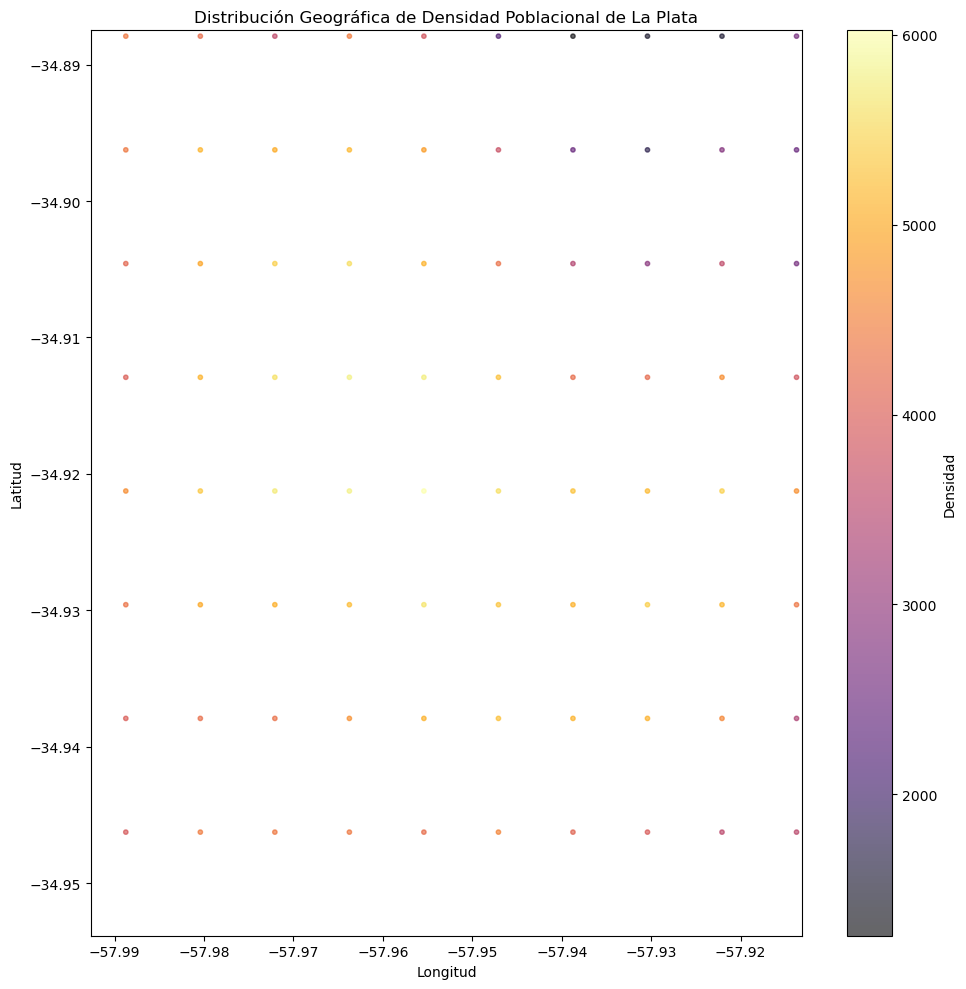

In [20]:
# Visualización de la densidad poblacional de La Plata
fig, axes = plt.subplots(figsize=(10, 10))

# Gráfico de dispersión geográfica
scatter = axes.scatter(
    gdf_densidad['X'], gdf_densidad['Y'], c=gdf_densidad['Z'],
    cmap='inferno', alpha=0.6, s=10
)
axes.set_xlabel('Longitud')
axes.set_ylabel('Latitud')
axes.set_title('Distribución Geográfica de Densidad Poblacional de La Plata')

# Ajustar límites del gráfico según los límites de La Plata
axes.set_xlim(bounds['x_min'], bounds['x_max'])
axes.set_ylim(bounds['y_min'], bounds['y_max'])


plt.colorbar(scatter, ax=axes, label='Densidad')
plt.tight_layout()
plt.savefig('densidad_la_plata.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
def clip_density_to_urban_area(gdf_density: gpd.GeoDataFrame, gdf_geographical: gpd.GeoDataFrame) -> gpd.GeoDataFrame: 
    """
    Recorta los puntos de densidad que caen dentro del casco urbano de un límite geográfico dado.
    
    Args:
        gdf_density: GeoDataFrame con datos de densidad
        gdf_geographical: GeoDataFrame con límites geográficos

    Returns:
        gpd.GeoDataFrame: GeoDataFrame recortado a la zona urbana
    """
    # Usar uniones espaciales para mantener solo puntos dentro del casco urbano
    points_in_casco = gpd.sjoin(gdf_density, gdf_geographical, how='inner', predicate='intersects')
    
    # Limpiar columnas duplicadas del join 
    points_in_casco = points_in_casco.drop(columns=[col for col in points_in_casco.columns if col.endswith('_right')]) 
    
    return points_in_casco

In [22]:
casco_urbano = clip_density_to_urban_area(gdf_densidad, gdf_geographical= gdf)

In [23]:
casco_urbano

,X,Y,Z,geometry,densidad_poblacional_lp,Name,Description
22,-57.972083,-34.904583,5416.428223,POINT (-57.97208 -34.90458),5416.428223,La Plata,descripción: <br>name: La Plata <br>descriptio...
31,-57.980416,-34.912916,5103.672852,POINT (-57.98042 -34.91292),5103.672852,La Plata,descripción: <br>name: La Plata <br>descriptio...
33,-57.963750,-34.912916,5795.110352,POINT (-57.96375 -34.91292),5795.110352,La Plata,descripción: <br>name: La Plata <br>descriptio...
36,-57.938750,-34.912916,4231.409668,POINT (-57.93875 -34.91292),4231.409668,La Plata,descripción: <br>name: La Plata <br>descriptio...
43,-57.963750,-34.921250,5794.330078,POINT (-57.96375 -34.92125),5794.330078,La Plata,descripción: <br>name: La Plata <br>descriptio...
53,-57.963750,-34.929583,5190.817871,POINT (-57.96375 -34.92958),5190.817871,La Plata,descripción: <br>name: La Plata <br>descriptio...
54,-57.955416,-34.929583,5635.426758,POINT (-57.95542 -34.92958),5635.426758,La Plata,descripción: <br>name: La Plata <br>descriptio...
56,-57.938750,-34.929583,5082.848633,POINT (-57.93875 -34.92958),5082.848633,La Plata,descripción: <br>name: La Plata <br>descriptio...
64,-57.955416,-34.937916,5090.878418,POINT (-57.95542 -34.93792),5090.878418,La Plata,descripción: <br>name: La Plata <br>descriptio...
74,-57.955416,-34.946250,4224.697266,POINT (-57.95542 -34.94625),4224.697266,La Plata,descripción: <br>name: La Plata <br>descriptio...


In [24]:
# Convertir a Web Mercator (sist. de proyección cartográfica EPSG 3857)
casco_utm = casco_urbano.to_crs(epsg=3857)

In [26]:
# Crear un GeoDataFrame con los límites del área de La Plata en EPSG:4326
gdf_bounds_4326 = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# Transformar al CRS del plot
gdf_bounds_utm = gdf_bounds_4326.to_crs(casco_utm.crs)

# Obtener límites en coordenadas proyectadas
bounds_proj = gdf_bounds_utm.total_bounds  # [xmin, ymin, xmax, ymax]

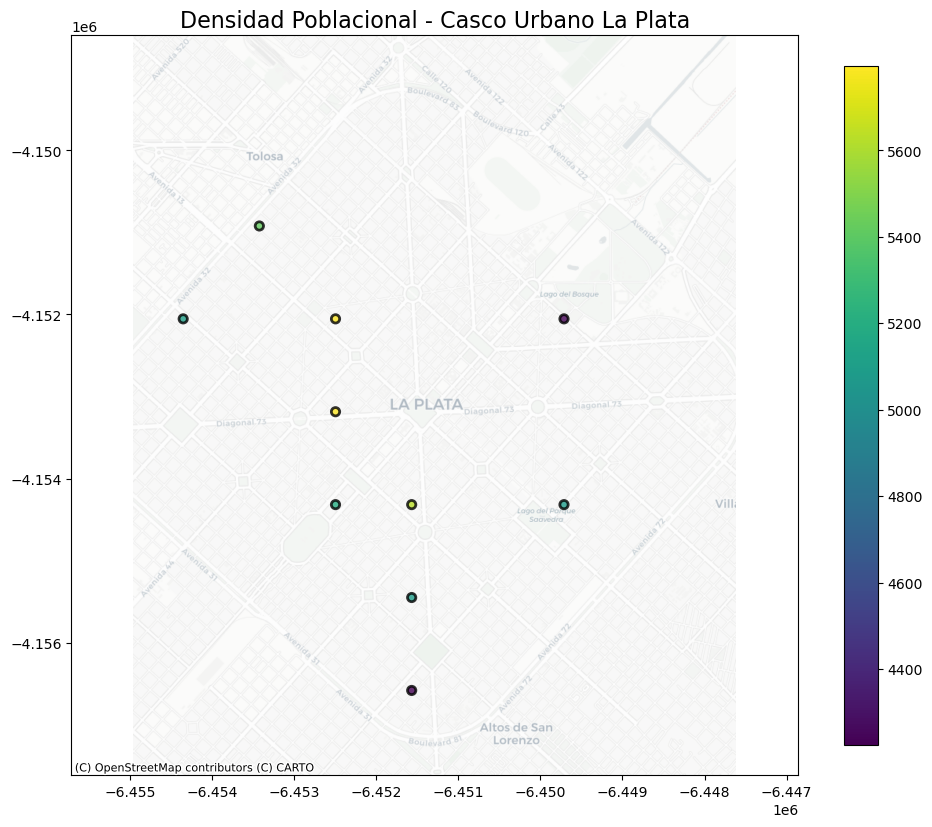

In [29]:
# Plotear usando un mapa base más clara y con mayor contraste
fig, ax = plt.subplots(figsize=(10, 10))

casco_utm.plot(column='densidad_poblacional_lp', 
               cmap='viridis',  
               alpha=0.8,    
               edgecolor='black',
               linewidth=2,
               ax=ax,
               legend=True,
               legend_kwds={'shrink': 0.7})

# Mapa base
ctx.add_basemap(ax, crs=casco_utm.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron,  # Fondo más claro
                alpha=0.7)  

ax.set_title('Densidad Poblacional - Casco Urbano La Plata', fontsize=16)
ax.axis('on')

# Ajustar límites del gráfico según los límites de La Plata
ax.set_xlim(bounds_proj[0], bounds_proj[2])
ax.set_ylim(bounds_proj[1], bounds_proj[3])

plt.tight_layout()
plt.show()

In [ ]:
# Visualización de la densidad poblacional de La Plata usando kriging

# Extraer coordenadas de los centroides,y valores desde el GeoDataFrame
coords =np.array([[point.x, point.y] for point in casco_utm.geometry.centroid]) 
values_density = casco_urbano['densidad_poblacional_lp'].values

print(f"Puntos de datos: {len(coords)}")    
print(f"Rango de valores: {values_density.min():.2f} - {values_density.max():.2f}")

# Crear grid de puntos para interpolación
bounds_casco_lp = casco_utm.total_bounds
grid_x, grid_y = np.mgrid[bounds_casco_lp[0]:bounds_casco_lp[2]:150j, bounds_casco_lp[1]:bounds_casco_lp[3]:150j]
grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])

#Definir kernel para el modelo de kriging
kernel = (ConstantKernel(1.0) * RBF(length_scale=1000.0) + 
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e3)))

# Crear modelo de kriging
gpr = GaussianProcessRegressor(kernel=kernel,
                                n_restarts_optimizer=10,
                                alpha=1e-04,
                                normalize_y=True)

# Entrenar el modelo
gpr.fit(coords, values_density)

#Predecir en el grid
grid_2_kriging, pred_std = gpr.predict(grid_coords, return_std=True)
grid_z = grid_2_kriging.reshape(grid_x.shape)
grid_uncertainty = pred_std.reshape(grid_x.shape)

# Visualización de la superficie Kriging interpolada
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear superficie Kriging interpolada
contour = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis', alpha=0.7)

# Plotear los polígonos originales con bordes
casco_utm.plot(column='densidad_poblacional_lp', 
               cmap='viridis',
               alpha=0.5,
               edgecolor='black',
               linewidth=1.0,
               ax=ax)

# Plotear los puntos centroides
scatter = ax.scatter(coords[:, 0], coords[:, 1],
                    c=values_density,
                    cmap='viridis',
                    s=30,
                    edgecolors='black',
                    linewidths=1,
                    zorder=5)

#Mapa base más sutil
ctx.add_basemap(ax, crs=casco_utm.crs.to_string(),
               source=ctx.providers.CartoDB.Positron,
               alpha = 0.9)

# Agregar colorbar para el scatter
plt.colorbar(scatter, ax=ax, label='Densidad poblacional',shrink=0.7, aspect=25)

# Agregar título y etiquetas
ax.set_title('Interpolación Kriging - Densidad Poblacional La Plata')
ax.set_xlabel('X (UTM)')
ax.set_ylabel('Y (UTM)')

plt.tight_layout()
plt.show()

In [ ]:
def export_to_geotiff(grid_data: np.ndarray, gdf: gpd.GeoDataFrame, filename: str, crs_epsg: int = 3857):
    """
    Exporta una grilla (raster 2D) a un archivo GeoTIFF usando los límites geográficos de un GeoDataFrame.
    
    Parámetros:
    - grid_data: np.ndarray 2D, la grilla interpolada (como grid_z)
    - gdf: GeoDataFrame con CRS definido
    - filename: str, nombre de salida
    - crs_epsg: entero del sistema de coordenadas (ej. 3857)
    """
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    height, width = grid_data.shape

    # Calcula la transformación georreferenciada
    transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=grid_data.dtype,
        crs=CRS.from_epsg(crs_epsg),
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(grid_data, 1)
        dst.set_band_description(1, 'Densidad Poblacional Kriging')

    print(f"Archivo exportado correctamente: {filename}")


In [ ]:
# Exportar superficie interpolada
export_to_geotiff(grid_z, casco_utm, 'kriging_densidad_poblacional.tif', 3857)

# Etapa 5 : superposición de mapas de densidad y peligrosidad de inundación de la ciudad de La Plata (QGIS).